In [1]:
%matplotlib inline
from bokeh.io import output_notebook
from bokeh.plotting import *
from matmodlab2 import *
from numpy import *
output_notebook()
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt

Setting up the Matmodlab notebook environment


Loading BokehJS ...

In [2]:
tests_to_run = [
                'von_mises_no_transformation',
                'von_mises_transformation_hardening'
                # 1,
                # 2, 
                # 3, 
                # 4
                ]

def run_ST_GPSR_TTM(property_dict, loads='ESS', components=(0.02, 0, 0), frames=50):
    mps1 = MaterialPointSimulator('ST_GPSR_TTM')
    mps1.material = ST_GPSR_TTM(**property_dict)
    mps1.run_step(loads,  components, frames=frames)
    return mps1

def run_CPA_alg(property_dict, loads='ESS', components=(0.02, 0, 0), frames=50):
    mps1 = MaterialPointSimulator('CPAPlasticitiy')
    mps1.material = ST_GPSR_TTM(**property_dict)
    mps1.run_step(loads,  components, frames=frames)
    return mps1

def run_generic_mps(mps1, property_dict, loads='ESS', components=(0.02, 0, 0), frames=50):
    mps1.run_step(loads,  components, frames=frames)
    return mps1

# Von Mises No Transformation w/ Hardening
What this test should show is that with an identity B matrix, that it matches a directly implemented VM-perfectly plastic model.

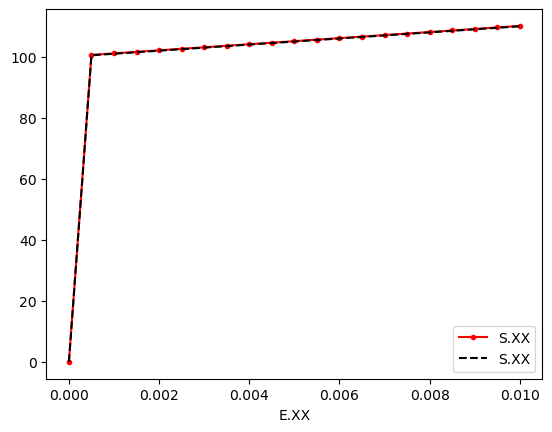

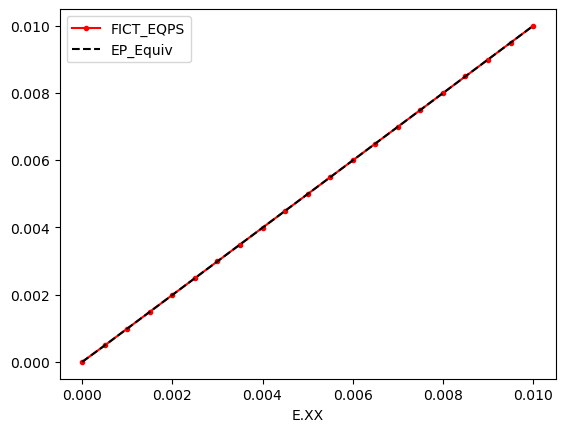

In [3]:
if 'von_mises_no_transformation' in tests_to_run:
    def B(eqps):
        B_in = np.eye(3)
        return B_in

    # Shared params
    E = 10e6
    nu = .333
    Y0 = 100
    H = 1000

    all_comps = (0.01, 0, 0)
    all_loads = 'ESS'
    all_frames = 20

    # Run ST_GPSR_TTM model
    pGPSR = {'E': E, 'Nu': nu, 'Y0': Y0, 'H': H, "B": B}
    mpsGPSR = run_ST_GPSR_TTM(pGPSR, frames=all_frames, components=all_comps, loads=all_loads)
    # Run the included von mises model
    pVM = {'E': E, 'Nu': nu, 'Y0': Y0, 'Y1': H, 'm': 1.0}
    mpsVM = MaterialPointSimulator('VM_Plastic')
    mpsVM.material = HardeningPlasticMaterial(**pVM)
    mpsVM = run_generic_mps(mpsVM, pVM, frames=all_frames, components=all_comps, loads=all_loads)

    ax = mpsGPSR.plot('E.XX', 'S.XX', style='.r-')
    mpsVM.plot('E.XX', 'S.XX', ax=ax, style='k--')

    ax2 = mpsGPSR.plot('E.XX', 'FICT_EQPS', style='.r-')
    mpsVM.plot('E.XX', 'EP_Equiv', ax=ax2, style='k--')

    # print(mpsGPSR.df[['FICT_EQPS', 'Y']])
    # print(mpsVM.df[['EP_Equiv', 'S.XX']])
    # with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #     df = mpsGPSR.df[['E.XX', 'MML_STRESS_GUESS',  'TRIAL_STRESS_PRE_TRANS', 'FICT_EQPS_INPUT', 'TRIAL_STRESS_POST_TRANS', 'CONV_STRESS_ISO', 'CONV_STRESS_REAL', 'FICT_EQPS', 'S.XX', 'DELTA_EXX', 'DELTA_EYY', 'DELTA_EZZ']]
    #     df.to_csv('output1.csv')
    #     print(df)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        df_vm_reference = mpsGPSR.df[['E.XX', 
                        'MML_STRESS_GUESS_XX',
                        'MML_STRESS_GUESS_YY',
                        'MML_STRESS_GUESS_ZZ',
                        'DELTA_EXX',
                        'DELTA_EYY',
                        'DELTA_EZZ',
                        'TRIAL_STRESS_PRE_TRANS_XX',
                        'TRIAL_STRESS_PRE_TRANS_YY',
                        'TRIAL_STRESS_PRE_TRANS_ZZ',
                        'DELTA_SXX',
                        'DELTA_SYY',
                        'DELTA_SZZ',
                        'TRIAL_STRESS_POST_TRANS_XX',
                        'TRIAL_STRESS_POST_TRANS_YY',
                        'TRIAL_STRESS_POST_TRANS_ZZ',
                        'CONV_STRESS_ISO_XX',
                        'CONV_STRESS_ISO_YY',
                        'CONV_STRESS_ISO_ZZ',
                        'FICT_SXX',
                        'FICT_SYY',
                        'FICT_SZZ',
                        "FICT_EP_XX",  # 0
                        "FICT_EP_YY",  # 1
                        "FICT_EP_ZZ",  # 2
                        'REAL_EP_XX',
                        'REAL_EP_YY',
                        'REAL_EP_ZZ',
                        'S.XX',
                        'S.YY',
                        'S.ZZ',
                        'S.YZ',
                        'S.XZ',
                        'S.XY',
                        'S.VM']]
        df_vm_reference.to_csv('output0.csv')


# Von Mises Identity Mapping w/ Hardening

In BINGO, we found a mapping between $P_{iso} = P_{vm}/(Y_0 + H \varepsilon_{eq})$, where $Y_0 = 100$ and $H = 1000$, and a synthetic von Mises dataset where $Y_0 = 100$ and $H = 1000$. So, there should be no errors, and VM should match a standard VM model with hardening.

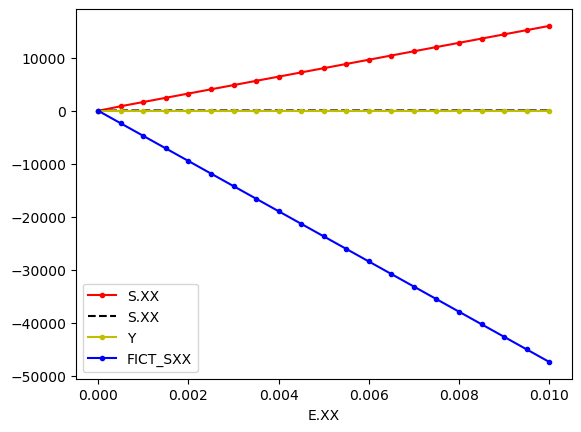

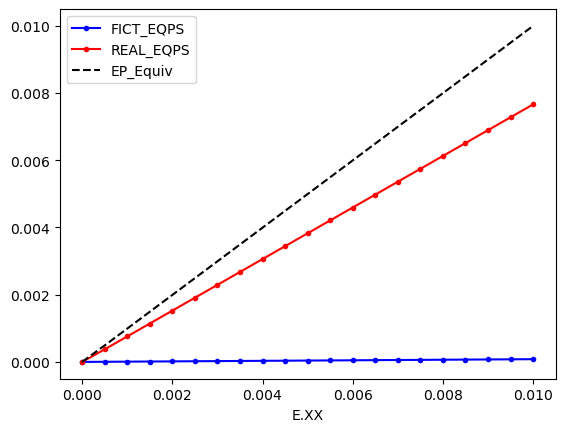

In [14]:
if 'von_mises_transformation_hardening' in tests_to_run:
    ISO_Y0 = 100
    ISO_H = 10000

    def B(X_0):
        B_in =  (X_0) * ((array([[ 18.08907686,   5.89082086,  -8.89717253],
            [ 12.15223217, -20.78122556,   3.11622233],
            [-25.79412594,  10.56311936,  -0.35491868]])) @ ((array([[ 18.08907686,   5.89082086,  -8.89717253],
            [ 12.15223217, -20.78122556,   3.11622233],
            [-25.79412594,  10.56311936,  -0.35491868]])) * (X_0) + array([[-0.75053343, -0.06581181,  1.0025247 ],
            [-0.59793633,  1.30128027,  0.11761457],
            [ 1.92747602, -0.41840671,  0.89562932]]))) + (array([[ 0.00245173, -1.15900455, -1.16177952],
            [-0.66576521, -0.49507749,  0.59528929],
            [-0.43569645,  0.38069598, -0.69586331]])) @ (array([[ 0.00245173, -1.15900455, -1.16177952],
            [-0.66576521, -0.49507749,  0.59528929],
            [-0.43569645,  0.38069598, -0.69586331]]))  # This is taken from VM_1 dataset

        return B_in
    #print(B(0))
    #exit
    #print([B(i) for i in [1,2,3,4,5]])
    

    # Shared params
    E = 10e6
    nu = .333
    Y0 = 100
    H = 10000

    all_comps = (0.01, -0.005, -0.005)
    all_loads = 'EEE'
    all_frames = 20

    # Run ST_GPSR_TTM model
    pGPSR = {'E': E, 'Nu': nu, 'Y0': ISO_Y0, 'H': ISO_H, "B": B}
    mpsGPSR = run_ST_GPSR_TTM(pGPSR, frames=all_frames, components=all_comps, loads=all_loads)

    # Run the included von mises model
    pVM = {'E': E, 'Nu': nu, 'Y0': Y0, 'Y1': H, 'm': 1 }
    mpsVM = MaterialPointSimulator('VM_Plastic')
    mpsVM.material = HardeningPlasticMaterial(**pVM)
    mpsVM = run_generic_mps(mpsVM, pVM, frames=all_frames, components=all_comps, loads=all_loads)

    # pFict = {'E': E, 'Nu': nu, 'Y0': ISO_Y0, 'Y1': ISO_H, "m": 1}
    # mpsFictSolver = MaterialPointSimulator('VM_Plastic')
    # mpsFictSolver.material = HardeningPlasticMaterial(**pFict)
    # mpsFictSolver = run_generic_mps(mpsFictSolver, pGPSR, frames=all_frames, components=all_comps, loads=all_loads)

    ax = mpsGPSR.plot('E.XX', 'S.XX', style='.r-')
    mpsVM.plot('E.XX', 'S.XX', ax=ax, style='k--')
    mpsGPSR.plot('E.XX', 'Y', style='.y-',  ax=ax)
    mpsGPSR.plot('E.XX', 'FICT_SXX', style='.b-',  ax=ax)
    # mpsFictSolver.plot('E.XX', 'S.XX', style='k--', ax=ax)


    # ax3 = mpsGPSR.plot('E.XX', 'DEBUG1', style='.m-')
    # mpsGPSR.plot('E.XX', 'DEBUG2', style='.c-',  ax=ax3)

    ax2 = mpsGPSR.plot('E.XX', 'FICT_EQPS', style='.b-')
    mpsGPSR.plot('E.XX', 'REAL_EQPS', style='.r-',  ax=ax2)
    
    mpsVM.plot('E.XX', 'EP_Equiv', ax=ax2, style='k--')
    # with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #     df = mpsGPSR.df[['E.XX', 'MML_STRESS_GUESS',  'TRIAL_STRESS_PRE_TRANS', 'FICT_EQPS_INPUT', 'TRIAL_STRESS_POST_TRANS', 'CONV_STRESS_ISO', 'CONV_STRESS_REAL', 
    #                      'FICT_EQPS', 'S.XX', 'S.YY', 'S.ZZ', 'DELTA_EXX', 'DELTA_EYY', 'DELTA_EZZ']]
    #     df.to_csv('output2.csv')
    #     #print(df)




In [5]:
if 1 == 0:
    analytical_fictitous_solver = mpsFictSolver.df[['S.XX', 'S.YY', 'S.ZZ', 'S.YZ', 'S.XZ', 'S.XY']]

    GPSR_fictitious_values = mpsGPSR.df[['FICT_SXX', 'FICT_SYY', 'FICT_SZZ', 'FICT_SYZ', 'FICT_SXZ', 'FICT_SXY']]
    def break_stress_df_into_vm_array(stress_dataframe):
        sigma_11, sigma_22, sigma_33, sigma_12, sigma_23, sigma_13 = np.hsplit(stress_dataframe.to_numpy(),6)
        ROOT2 = np.sqrt(2)
        # print(sigma_12)
        sigma_12 = sigma_12*1./ROOT2
        sigma_23 = sigma_23*1./ROOT2
        sigma_13 = sigma_13*1./ROOT2
        vm_test = np.sqrt(0.5*((sigma_11 - sigma_22)**2 + (sigma_22 - sigma_33)**2 + (sigma_33 - sigma_11)**2 + 3*(sigma_23**2 + sigma_13**2 + sigma_12**2)))
        return vm_test

    vm_analytical = break_stress_df_into_vm_array(analytical_fictitous_solver)
    vm_GPSR_fict = break_stress_df_into_vm_array(GPSR_fictitious_values)

    stress_and_EQPS_of_FICT = mpsFictSolver.df[['S.XX', 'S.YY', 'S.ZZ', 'S.YZ', 'S.XZ', 'S.XY', 'EP_Equiv']]
    def deBug(X_0):
        B_in = (((array([[0.2]]))/(array([[0.2]]) + X_0 + X_0) ) * (array([[0.13364837]]))) * (array([[0.22540092, 0.15048297, 0.15061234],
            [0.15048297, 0.22521145, 0.15051772],
            [0.15061234, 0.15051772, 0.2254703 ]]))*(ISO_Y0 + ISO_H*X_0) 
        return B_in
    def run_fictitious_values_through_mapping_and_back(stress_and_eqps, mapping_func):
        temp = np.array(stress_and_eqps)
        shear_stresses = np.sum(temp[:,3:6])
        if np.abs(shear_stresses) > 1e-8:
            print('WARNING: non-negligible shear stress. This wont work.')
        axial_stress = temp[:,0:3]
        eqps = temp[:,6]

        trans_stress = np.zeros(axial_stress.shape)
        recovered_stress = np.zeros(axial_stress.shape)

        for i, (stress, e_vm) in enumerate(zip(axial_stress, eqps)):
            local_map = mapping_func(e_vm)
            #print(stress)
            trans_stress[i] = local_map @ stress
            recovered_stress[i] = np.linalg.inv(local_map) @ trans_stress[i]
        
        return trans_stress, recovered_stress
    trans_stress, recovered_stress = run_fictitious_values_through_mapping_and_back(stress_and_EQPS_of_FICT, deBug)

    plt.plot(vm_analytical, 'k', linewidth=5, label='Pure VM Model')
    plt.plot(vm_GPSR_fict, 'c--', label='Fictitious VM Stress from GPSR Constitutive Model')
    plt.plot(trans_stress[:,0], 'y--', label='Transformed (Pure VM) Stress')
    plt.plot(recovered_stress[:,0], 'm--', label='Recovered (Transformed) Stress')

    plt.legend()
    plt.show()

In [6]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    df = mpsGPSR.df[['E.XX', 
                    'MML_STRESS_GUESS_XX',
                    'MML_STRESS_GUESS_YY',
                    'MML_STRESS_GUESS_ZZ',
                    'DELTA_EXX',
                    'DELTA_EYY',
                    'DELTA_EZZ',
                    'TRIAL_STRESS_PRE_TRANS_XX',
                    'TRIAL_STRESS_PRE_TRANS_YY',
                    'TRIAL_STRESS_PRE_TRANS_ZZ',
                    'DELTA_SXX',
                    'DELTA_SYY',
                    'DELTA_SZZ',
                    'TRIAL_STRESS_POST_TRANS_XX',
                    'TRIAL_STRESS_POST_TRANS_YY',
                    'TRIAL_STRESS_POST_TRANS_ZZ',
                    'CONV_STRESS_ISO_XX',
                    'CONV_STRESS_ISO_YY',
                    'CONV_STRESS_ISO_ZZ',
                    'FICT_SXX',
                    'FICT_SYY',
                    'FICT_SZZ',
                    "FICT_EP_XX",  # 0
                    "FICT_EP_YY",  # 1
                    "FICT_EP_ZZ",  # 2
                    'REAL_EP_XX',
                    'REAL_EP_YY',
                    'REAL_EP_ZZ',
                    'S.XX',
                    'S.YY',
                    'S.ZZ',
                    'S.YZ',
                    'S.XZ',
                    'S.XY',
                    'S.VM']]
    df.to_csv('output1.csv')
    #print(df)

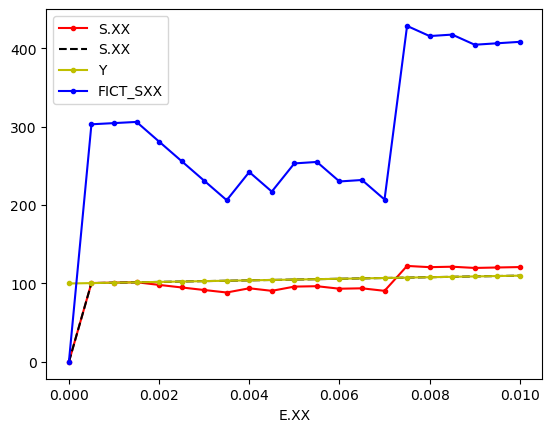

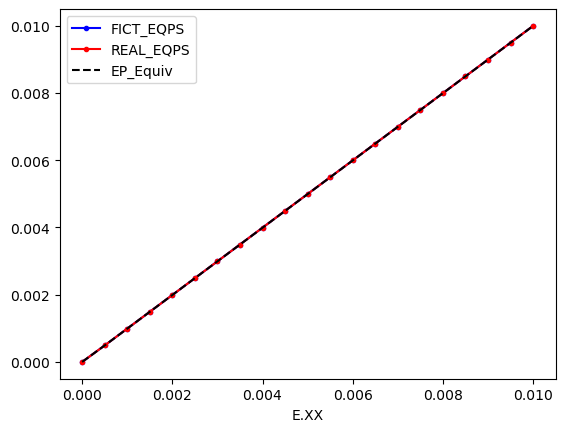

In [7]:
if 'von_mises_transformation_hardening' in tests_to_run:
    ISO_Y0 = 100
    ISO_H = 1000

    def B(X_0):
        B_in = (((array([[0.2]]))/(array([[0.2]]) + X_0 + X_0) ) * (array([[0.13364837]]))) * (array([[0.22540092, 0.15048297, 0.15061234],
            [0.15048297, 0.22521145, 0.15051772],
            [0.15061234, 0.15051772, 0.2254703 ]]))*(ISO_Y0 + ISO_H*X_0)   # This is taken from VM_1 dataset
        #B_in = np.eye(3)*2*(ISO_Y0 + ISO_H*X_0)
        return B_in
    #print(B(0))
    #exit
    #print([B(i) for i in [1,2,3,4,5]])
    

    # Shared params
    E = 10e6
    nu = .333
    Y0 = 100
    H = 1000

    all_comps = (0.01, 0, 0)
    all_loads = 'ESS'
    all_frames = 20

    # Run ST_GPSR_TTM model
    pGPSR = {'E': E, 'Nu': nu, 'Y0': ISO_Y0, 'H': ISO_H, "B": B}
    mpsGPSR = run_ST_GPSR_TTM(pGPSR, frames=all_frames, components=all_comps, loads=all_loads)

    # Run the included von mises model
    pVM = {'E': E, 'Nu': nu, 'Y0': Y0, 'Y1': H, 'm': 1 }
    mpsVM = MaterialPointSimulator('VM_Plastic')
    mpsVM.material = HardeningPlasticMaterial(**pVM)
    mpsVM = run_generic_mps(mpsVM, pVM, frames=all_frames, components=all_comps, loads=all_loads)

    #pFict = {'E': E, 'Nu': nu, 'Y0': ISO_Y0, 'Y1': ISO_H, "m": 1}
    #mpsFictSolver = MaterialPointSimulator('VM_Plastic')
    #mpsFictSolver.material = HardeningPlasticMaterial(**pFict)
    #mpsFictSolver = run_generic_mps(mpsFictSolver, pGPSR, frames=all_frames, components=all_comps, loads=all_loads)

    ax = mpsGPSR.plot('E.XX', 'S.XX', style='.r-')
    mpsVM.plot('E.XX', 'S.XX', ax=ax, style='k--')
    mpsGPSR.plot('E.XX', 'Y', style='.y-',  ax=ax)
    mpsGPSR.plot('E.XX', 'FICT_SXX', style='.b-',  ax=ax)
    #mpsFictSolver.plot('E.XX', 'S.XX', style='k--', ax=ax)


    # ax3 = mpsGPSR.plot('E.XX', 'DEBUG1', style='.m-')
    # mpsGPSR.plot('E.XX', 'DEBUG2', style='.c-',  ax=ax3)

    ax2 = mpsGPSR.plot('E.XX', 'FICT_EQPS', style='.b-')
    mpsGPSR.plot('E.XX', 'REAL_EQPS', style='.r-',  ax=ax2)
    
    mpsVM.plot('E.XX', 'EP_Equiv', ax=ax2, style='k--')
    # with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #     df = mpsGPSR.df[['E.XX', 'MML_STRESS_GUESS',  'TRIAL_STRESS_PRE_TRANS', 'FICT_EQPS_INPUT', 'TRIAL_STRESS_POST_TRANS', 'CONV_STRESS_ISO', 'CONV_STRESS_REAL', 
    #                      'FICT_EQPS', 'S.XX', 'S.YY', 'S.ZZ', 'DELTA_EXX', 'DELTA_EYY', 'DELTA_EZZ']]
    #     df.to_csv('output2.csv')
    #     #print(df)




In [8]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    df_vm_GPSR = mpsGPSR.df[['E.XX', 
                    'MML_STRESS_GUESS_XX',
                    'MML_STRESS_GUESS_YY',
                    'MML_STRESS_GUESS_ZZ',
                    'DELTA_EXX',
                    'DELTA_EYY',
                    'DELTA_EZZ',
                    'TRIAL_STRESS_PRE_TRANS_XX',
                    'TRIAL_STRESS_PRE_TRANS_YY',
                    'TRIAL_STRESS_PRE_TRANS_ZZ',
                    'DELTA_SXX',
                    'DELTA_SYY',
                    'DELTA_SZZ',
                    'TRIAL_STRESS_POST_TRANS_XX',
                    'TRIAL_STRESS_POST_TRANS_YY',
                    'TRIAL_STRESS_POST_TRANS_ZZ',
                    'CONV_STRESS_ISO_XX',
                    'CONV_STRESS_ISO_YY',
                    'CONV_STRESS_ISO_ZZ',
                    'FICT_SXX',
                    'FICT_SYY',
                    'FICT_SZZ',
                    "FICT_EP_XX",  # 0
                    "FICT_EP_YY",  # 1
                    "FICT_EP_ZZ",  # 2
                    'REAL_EP_XX',
                    'REAL_EP_YY',
                    'REAL_EP_ZZ',
                    'S.XX',
                    'S.YY',
                    'S.ZZ',
                    'S.YZ',
                    'S.XZ',
                    'S.XY',
                    'S.VM']]
    df_vm_GPSR.to_csv('output2.csv')
    #print(df)

(-95.25976991386507, 90.07391656927915, -89.81462390204986, 89.81462390204986)

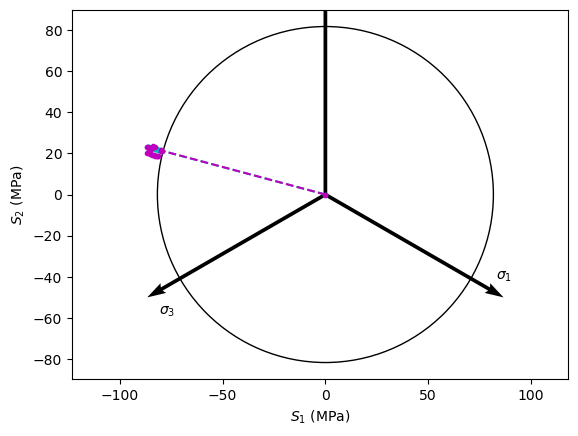

In [9]:
def align_pi_plane_with_axes_rot():
    """
    Returns a matrix that rotates the pi plane's normal to be the z axis
    i.e., a slice of pi plane becomes the xy plane after rotation
    """
    pi_vector = np.array([1, 1, 1]) / np.sqrt(3.)
    # wanted_vector = np.array([1, 0, 0])
    wanted_vector = np.array([0, 0, 1])
    wanted_vector = wanted_vector / np.linalg.norm(wanted_vector)
    added = (pi_vector + wanted_vector).reshape([-1, 1])
    # from Rodrigues' rotation formula, more info here: https://math.stackexchange.com/a/2672702
    rot_mat = 2 * (added @ added.T) / (added.T @ added) - np.eye(3)
    return rot_mat


def align_axes_with_pi_plane_rot():
    """
    Returns a matrix that undoes the align_pi_plane_with_axes_rot rotation
    """
    return np.linalg.inv(align_pi_plane_with_axes_rot())

def draw_principal_axes(ax, length_of_axes=2.5, scale=100):
    """
    Draws principal axes on graph, change length of axes and scale
    """
    zero_pos = np.zeros(2)
    straight_up_pos = np.array([0, 1]) * length_of_axes
    bottom_right_pos = np.array([np.cos(-np.pi / 6.), np.sin(-np.pi / 6.)]) * length_of_axes
    bottom_left_pos = np.array([np.cos(7 * np.pi / 6.), np.sin(7 * np.pi / 6.)]) * length_of_axes

    ax.quiver(*zero_pos, *straight_up_pos, scale_units="xy", scale=1)
    ax.annotate(r"$\sigma_2$", straight_up_pos + np.array([0.25, -0.3]) * scale)

    ax.quiver(*zero_pos, *bottom_right_pos, scale_units="xy", scale=1)
    ax.annotate(r"$\sigma_1$", bottom_right_pos + np.array([-0.18, 0.45]) * scale)

    ax.quiver(*zero_pos, *bottom_left_pos, scale_units="xy", scale=1)
    # ax.annotate(r"$\sigma_3$", bottom_left_pos + np.array([0.1, -0.45]) * scale)
    ax.annotate(r"$\sigma_3$", bottom_left_pos + np.array([0.28, -0.4]) * scale)
    # ax.annotate(r"$\sigma_3$", bottom_left_pos + np.array([-0.18, -0.4]) * scale)

stresses_reference = np.array(df_vm_reference[['S.XX', 'S.YY', 'S.ZZ']])
pi_plane_reference = stresses_reference @ align_axes_with_pi_plane_rot()

stresses_GPSR = np.array(df_vm_GPSR[['S.XX', 'S.YY', 'S.ZZ']])
pi_stresses_GPSR = stresses_GPSR @ align_axes_with_pi_plane_rot()

# fict_stresses_GPSR = np.array(df_vm_GPSR[['FICT_SXX', 'FICT_SYY', 'FICT_SZZ']])
# pi_fict_stresses_GPSR = fict_stresses_GPSR @ align_axes_with_pi_plane_rot()

f, ax = plt.subplots()
ax.plot(pi_plane_reference[:,0], pi_plane_reference[:,1], 'c.--', label='Pure VM Model')
ax.plot(pi_stresses_GPSR[:,0], pi_stresses_GPSR[:,1], 'm.--', label='Stresses Real Space')
#ax.plot(pi_fict_stresses_GPSR[:,0], pi_fict_stresses_GPSR[:,1], 'r.--', label='Stresses Fictitious Space')
ax.plot()
draw_principal_axes(ax, length_of_axes=100, scale=20)
# 
# ax.set_ylim([-120, 120])
# ax.set_xlim([-150, 150])
c1 = plt.Circle( (0, 0 ),
                                      np.sqrt(2/3)*100 ,
                                      fill = False )
ax.add_patch(c1)
ax.set_xlabel("$S_1$ (MPa)")
ax.set_ylabel("$S_2$ (MPa)")
ax.axis("equal")



Text(0, 0.5, '$S_2$ (MPa)')

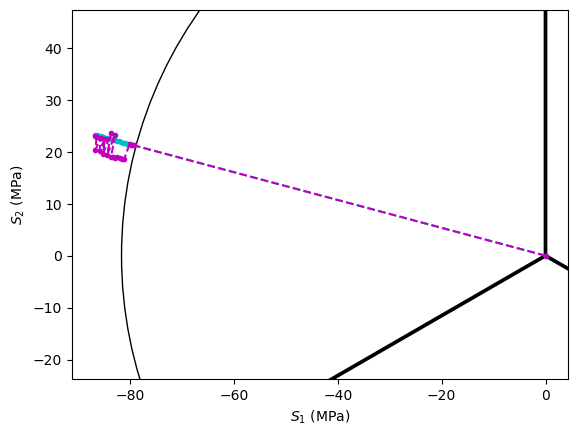

In [10]:
f, ax = plt.subplots()
ax.plot(pi_plane_reference[:,0], pi_plane_reference[:,1], 'c.--', label='Pure VM Model')
ax.plot(pi_stresses_GPSR[:,0], pi_stresses_GPSR[:,1], 'm.--', label='Stresses Real Space')
#ax.plot(pi_fict_stresses_GPSR[:,0], pi_fict_stresses_GPSR[:,1], 'r.--', label='Stresses Fictitious Space')
ax.plot()
draw_principal_axes(ax, length_of_axes=100, scale=20)
# 
ax.set_ylim([0, 50])
ax.set_xlim([-100, -50])
ax.axis("equal")
c1 = plt.Circle( (0, 0 ),
                                      np.sqrt(2/3)*100 ,
                                      fill = False )
ax.add_patch(c1)
ax.set_xlabel("$S_1$ (MPa)")
ax.set_ylabel("$S_2$ (MPa)")

